Examples of use of EGTtools
===========================

This notebook is aimed at displaying some of the main examples of use of Evolutionary Game Theoretical models and methods implemented in EGTtools.

## The replicator dynamics

The replicator equation is one of the fundamental descriptors of evolutionary dynamics. It consists on the following set of coupled ordinary diferencial equations:

$$
\dot x_{i} = x_{i} \left[f_i(\mathbf{x})-\sum_{j=1}^{N}{x_{j}f_j(x)}\right]
$$

This equation can also be expressed in the following vector form for symmetrical 2-player games:

$$
\dot x_{i} = x_{i} \left[(A \mathbf{x})_{i} - \mathbf{x} A \mathbf{x}\right]
$$

This last form is implemented in EGTtools in `egttools.analytical.replicator_equation`. This function takes as input a vector $\mathbf{x}$ containing the frequencies of each of the strategies (or types) in the population, and a matrix $A$ which contains the payoff of each strategy when interacting against any other strategy in the population. It will output the gradient of selection, i.e., the change in the population at the next time-step.

You can feed this function directly to `scypy` `odeint` function if you would like to integrate it and calculate the state of the population at a given point in time.

You can also plot the gradient of selection to visually identify the roots of the dynamical system:

In [1]:
import numpy as np
import egttools as egt
import matplotlib.pylab as plt
%matplotlib inline
# Required to avoid issues with svg images and fonts
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
SAVE_PATH = "../figures"
SAVE = True

### Replicator dynamics in a 1-Simplex (only 2 strategies)

We first look at the replicator dinynamics in a system with only 2 strategies. Thus, we can visualize the dynamics through the gradient of selection and the selection direction can be plot in a single line.

In [3]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [4]:
A

array([[-0.5,  2. ],
       [ 0. ,  0. ]])

We can calculate the gradients in the following way:

In [5]:
nb_points = 101
strategy_i = np.linspace(0, 1, num=nb_points, dtype=np.float64)

In [6]:
# Calculate gradient
gradient_function = lambda x: egt.analytical.replicator_equation(x, A)
gradients = egt.analytical.utils.calculate_gradients(np.array((strategy_i, 1 - strategy_i)).T, 
                                                     gradient_function)

When we are analysing a pairwise game with the replicator equation, we can also calculate the roots of the system and their stability:

In [7]:
roots = egt.analytical.utils.find_roots(gradient_function, 2, 
                                        nb_initial_random_points=10,
                                       method="hybr")
stability = egt.analytical.utils.check_replicator_stability_pairwise_games(roots, A, atol_neg=1e-4, atol_pos=1e-4, atol_zero=1e-4)

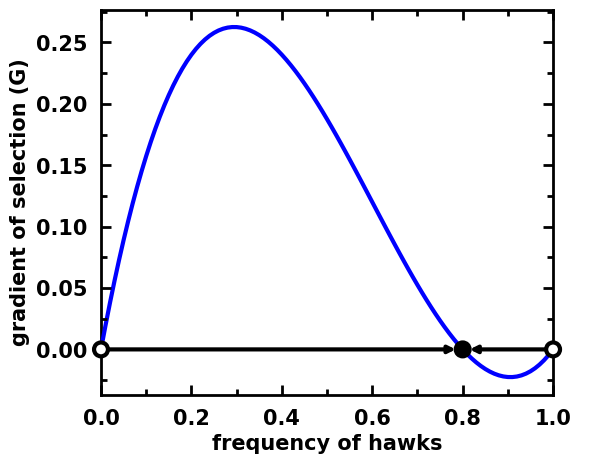

In [8]:
egt.plotting.indicators.plot_gradients(gradients[:, 0], 
                                       xlabel="frequency of hawks", 
                                       roots=roots, stability=stability)
if SAVE:
    plt.savefig("{}/hawk_dove_replicator_gradient.svg".format(SAVE_PATH), dpi=300, bbox_inches='tight')

It is also possible to make the same plot without showing the stationary points. This is the indicated use when plotting the gradient of stochastic dynamics in finite populations:

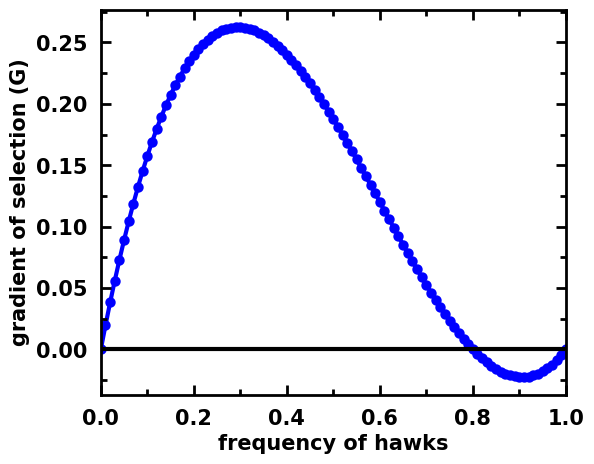

In [9]:
egt.plotting.indicators.plot_gradients(gradients[:, 0], xlabel="frequency of hawks", marker='o', figsize=(6,5))

if SAVE:
    plt.savefig("{}/hawk_dove_replicator_gradient_noroots.svg".format(SAVE_PATH), dpi=300, bbox_inches='tight')

### Replicator dynamics in a 2-simplex (3 strategies)

When we have 3 strategies, we can visualize the replicator dynamics over a 2-simples (a triangle). This can be easily achieved in EGTtools through the Simplex2D class:

In [10]:
from egttools.plotting.simplified import plot_replicator_dynamics_in_simplex

In [11]:
# Payoff matrix
V = 2; D = 3; T = 1; F = 2; S = 1
A = np.array([
        [ (V-D)/2, V, 0], # Hawk
        [ 0      , (V/2) - T, F], # Dove
        [ 0      , S, 0] # Human
    ])
type_labels = ['Hawk', 'Dove', 'Human']

In [12]:
A

array([[-0.5,  2. ,  0. ],
       [ 0. ,  0. ,  2. ],
       [ 0. ,  1. ,  0. ]])

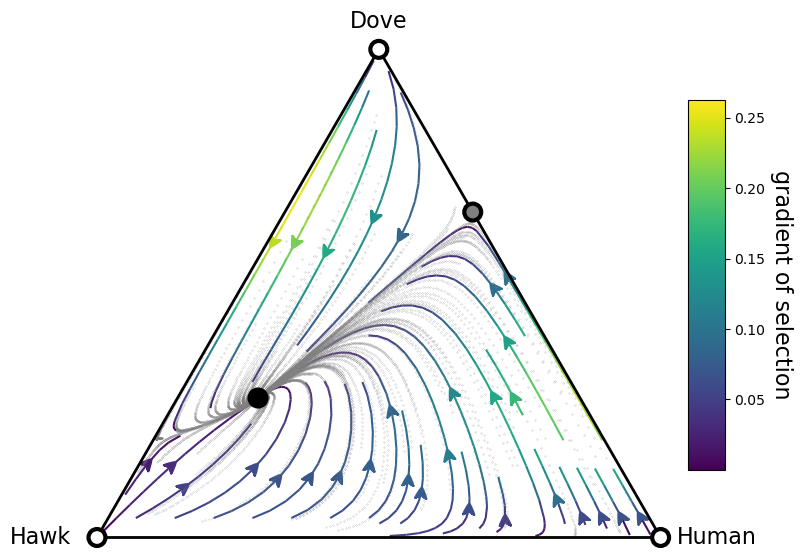

In [13]:
fig, ax = plt.subplots(figsize=(10,8))

simplex, gradient_function, roots, roots_xy, stability = plot_replicator_dynamics_in_simplex(A, atol_equal=1e-2, ax=ax)

plot = (simplex.draw_triangle()
           .add_vertex_labels(type_labels, epsilon_bottom=0.1)
           .draw_stationary_points(roots_xy, stability)
           .draw_gradients(zorder=0)
           .add_colorbar()
           .draw_scatter_shadow(gradient_function, 100, color='gray', marker='.', s=0.1)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))

if SAVE:
    plt.savefig("{}/hawk_dove_human_replicator_Simplex.pdf".format(SAVE_PATH), dpi=300, bbox_inches='tight')

## Stochastic Dynamics in Finite Populations - Moran process with pairwise comparison rule

Finite populations introduce stochastic effects. We can represent these dynamics, by adapting the replicator equation, which considers that individuals are sampled from an infinite population, and therefore selecting a member of strategy $j$ does not reduce its frequency in the population. When the population is finite, we may no longer assume a sampling with replacement, i.e., when an individual of strategy $j$ is sampled, the fraction of members of that strategy is reduced, instead we must sample without replacement.

Here the fitness of an strategy $i$ against strategy $j$ directly depends on the size of the population:

$f_i(x_i, Z) = \frac{x_i - 1}{Z-1} * A_{ii} + \frac{Z - x_i}{Z-1} * A_{ij}$

For the selection dynamics, we use a Moran process (or birth-death process) with pair-wise comparison: at each step, 2 individuals, $a$ and $b$, are randomly sampled (without replacement) from the population, and their payoff is compared. The fermi equation gives the probability that individual $a$ (selected for death) will copy the strategy of individual $b$ (selected for birth):

$p=[1 + e^{\beta(f_a-f_b)}]^{-1}$

$a$ will imitate $b$ with probability $p$, in any other case, the population state will not change. $\beta$ indicates the selection strength and on the limit $\beta \xrightarrow{} 0$ all strategies are immitated with equal probability.

In [14]:
Z = 100
beta = 1
mu = 1/Z

### Stochastic dynamics in a 1-Simplex (only 2 strategies)

Here we do not plot the roots, since the system is discrete and the gradient might jump to a negative value without becoming zero. Yet, we can still observe that the shape of the gradient is almost identical to the replicator dynamics.

In [15]:
from egttools.analytical import PairwiseComparison

In [16]:
# Payoff matrix
V = 2; D = 3; T = 1
A = np.array([
        [ (V-D)/2, V],
        [ 0      , (V/2) - T],
    ])

In [17]:
# Parameters and evolver
nb_strategies = 2; Z = 100; N = 2;
beta = 1
pop_states = np.arange(0, Z + 1, 1)
game = egt.games.Matrix2PlayerGameHolder(nb_strategies, A)
evolver = PairwiseComparison(Z, game)

In [18]:
gradients = np.array([evolver.calculate_gradient_of_selection(beta, np.array([x, Z-x])) for x in range(Z + 1)])

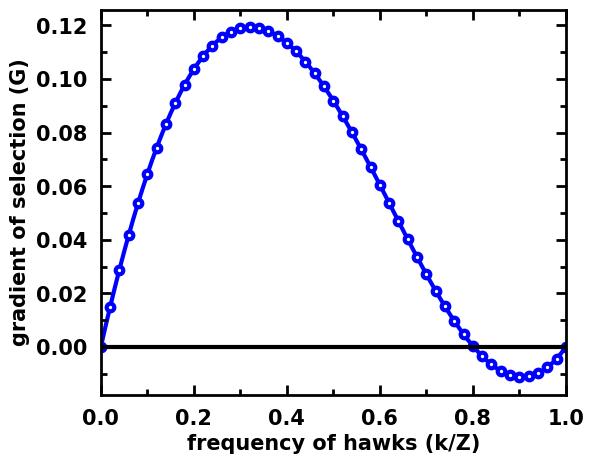

In [19]:
egt.plotting.indicators.plot_gradients(gradients[:, 0], figsize=(6,5), 
                                       marker_facecolor='white',
                                       xlabel="frequency of hawks (k/Z)", marker="o", marker_size=30, marker_plot_freq=2)

if SAVE:
    plt.savefig("{}/hawk_dove_moran_gradient.svg".format(SAVE_PATH), dpi=300, bbox_inches='tight')
    plt.savefig("{}/hawk_dove_moran_gradient.pdf".format(SAVE_PATH), dpi=300, bbox_inches='tight')

### Replicator dynamics in a 2-simplex (3 strategies)

Since it is not so simple to formally define the roots of a discrete system, we can make use of the stationary distribution of the Markov chain as an indication of where they are situated, and of how likely is the system to spend time in these equilibria.

In [20]:
from egttools.plotting.simplified import plot_pairwise_comparison_rule_dynamics_in_simplex_without_roots

In [21]:
# Payoff matrix
V = 2; D = 3; T = 1; F = 2; S = 1
A = np.array([
        [ (V-D)/2, V, 0], # Hawk
        [ 0      , (V/2) - T, F], # Dove
        [ 0      , S, 0] # Human
    ])
type_labels = ['Hawk', 'Dove', 'Human']

In [22]:
A

array([[-0.5,  2. ,  0. ],
       [ 0. ,  0. ,  2. ],
       [ 0. ,  1. ,  0. ]])

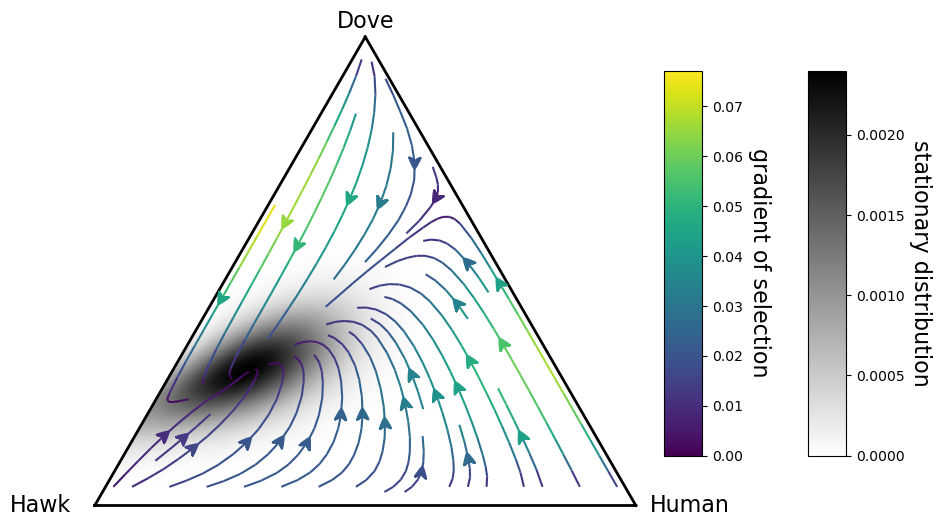

In [23]:
fig, ax = plt.subplots(figsize=(12,10))

simplex, gradient_functionm, game, evolver = plot_pairwise_comparison_rule_dynamics_in_simplex_without_roots(payoff_matrix=A, 
                                                                                                             group_size=2, 
                                                                                                             population_size=Z, 
                                                                                                             beta=beta, 
                                                                                                             ax=ax)

transitions = evolver.calculate_transition_matrix(beta=beta, mu=mu)
sd = egt.utils.calculate_stationary_distribution(transitions.transpose())

plot = (simplex
           .draw_triangle()
           .add_vertex_labels(type_labels, epsilon_bottom=0.1, epsilon_top=0.03)
           .draw_stationary_distribution(sd, alpha=1, shrink=0.5,
                                         edgecolors='gray', cmap='binary', shading='gouraud', zorder=0)
           .draw_gradients(zorder=2, linewidth=1.5)
           .add_colorbar(shrink=0.5)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))

if SAVE:
    plt.savefig("{}/hawk_dove_human_moran_Simplex.pdf".format(SAVE_PATH), bbox_inches='tight')
    plt.savefig("{}/hawk_dove_human_moran_Simplex.svg".format(SAVE_PATH), bbox_inches='tight')

## Draw a simulated trajectory in the simplex

In [24]:
# Payoff matrix
A = np.array([
        [ 0, -1, 1], # Hawk
        [ 1, 0, -1], # Dove
        [ -1, 1, 0] # Human
    ])
type_labels = ['Rock', 'Paper', 'Scisors']

In [25]:
Z = 10000
beta = 1

In [26]:
game = egt.games.Matrix2PlayerGameHolder(3, A)

In [27]:
numerical_evolver = egt.numerical.PairwiseComparisonNumerical(Z, game, 10000)

In [28]:
nb_states = egt.calculate_nb_states(Z, 3)

In [29]:
index = np.random.randint(nb_states)
trajectory = numerical_evolver.run(1000000, beta, 0.01, egt.sample_simplex(index, Z, 3))

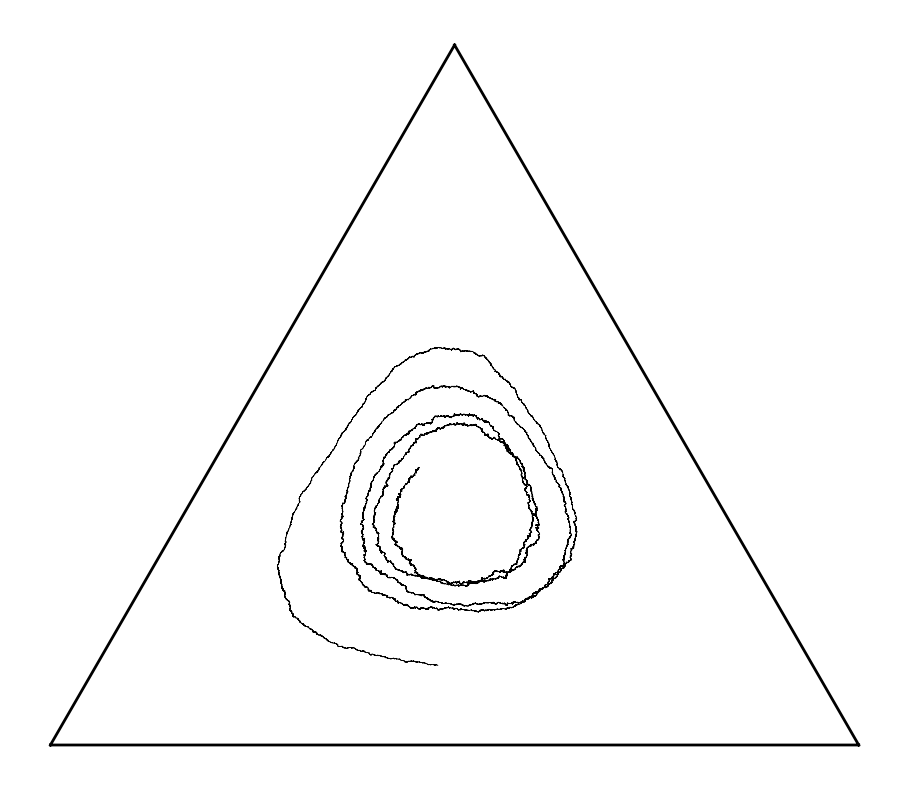

In [30]:
fig, ax = plt.subplots(figsize=(12,10))

simplex = egt.plotting.Simplex2D()

plot = (simplex.add_axis(ax=ax)
           .draw_triangle()
           .draw_trajectory_from_vector(trajectory / Z)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.show()

# plt.xlim((-.05,1.05))
# plt.ylim((-.02, simplex.top_corner + 0.05))

In [31]:
# Payoff matrix
V = 2; D = 3; T = 1; F = 2; S = 1
A = np.array([
        [ (V-D)/2, V, 0], # Hawk
        [ 0      , (V/2) - T, F], # Dove
        [ 0      , S, 0] # Human
    ])
type_labels = ['Hawk', 'Dove', 'Human']
game = egt.games.Matrix2PlayerGameHolder(3, A)

In [32]:
numerical_evolver = egt.numerical.PairwiseComparisonNumerical(Z, game, 10000)

In [33]:
nb_states = egt.calculate_nb_states(Z, 3)

In [34]:
index = np.random.randint(nb_states)
trajectory = numerical_evolver.run(1000000, beta, 0.01, egt.sample_simplex(index, Z, 3))

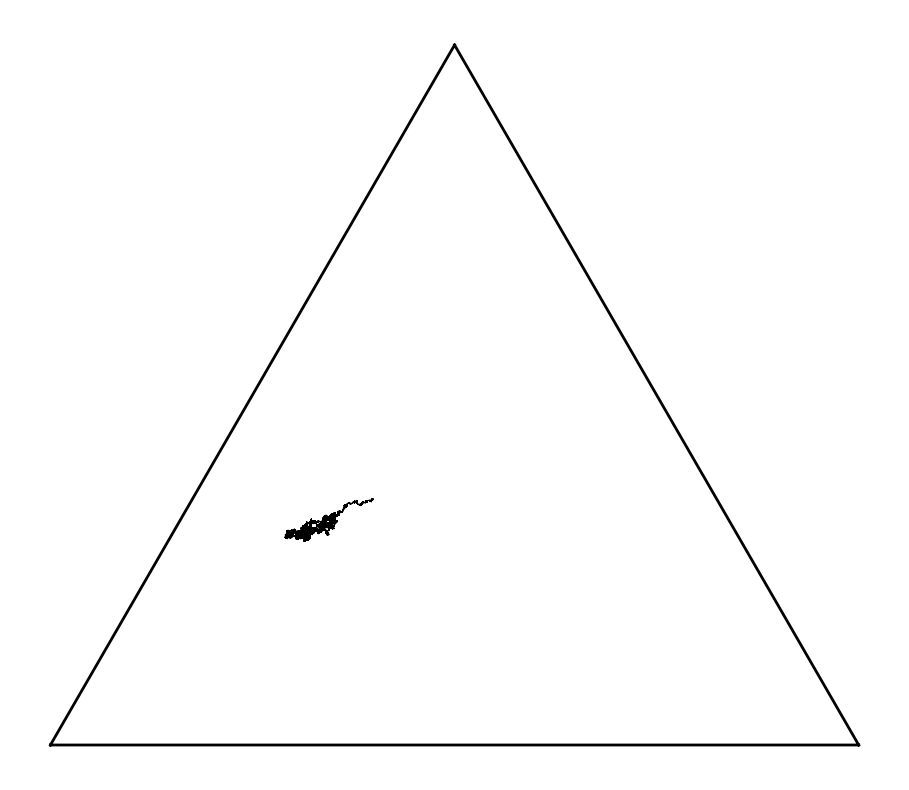

In [35]:
fig, ax = plt.subplots(figsize=(12,10))

simplex = egt.plotting.Simplex2D()

plot = (simplex.add_axis(ax=ax)
           .draw_triangle()
           .draw_trajectory_from_vector(trajectory / Z)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.show()